# About



`ITS_LIVE_TOOL` is a package designed to aid users working with the [Inter-mission Time Series of Land Ice Velocity and Elevation](link) (ITS_LIVE) dataset. The package provides functions for accessing data as well as various methods to process ITS_LIVE observations. This notebook will demonstrate various elements of the package and walk through the steps of a typical workflow using ITS_LIVE_TOOL. 

## Overview 

- Data Access
- Organization
- Data Processing
- Velocity Inversion

### Data Access + Organization

#### 1. Interactive map widget

This is an interactive widget design to streamline access ITS_LIVE image pair ice velocity time series. 

#### 2. Organization: `Glacier`, `Glacier_Centerline`, `Glacier_Point` objects

These are provided to store and keep track of different types of data related to individual units of analysis such as points, centerlines or full glacier surface areas. 

This roadmap document will first demonstrate data access and organization tools before demonstrating the processing tools. 

### Data Processing

We demonstrate and make available two processing routines. Be sure to check out the accompanying [book]() and consider if either of these are appropriate for your data and use case. Note that these methods are in active development and thus should be considered in *beta* phase. Please perform your own data inspection and due diligence if implementing these methods. 

#### Inversion

The Velocity Inversion solves ITS_LIVE's velocity timestamp issue. It inputs the length in time of all satellite pairs and recalculates a velocity that weighs each ITS_LIVE velocities falling withing the same time-window. It is a way of correcting and interpolating the dataset.


#### Gaussian Process Regression 

**to add**
Description -- link to full description and examples


### Processing

We demonstrate and make available two processing routines. Be sure to check out the accompanying [book]() and consider if either of these are appropriate for your data and use case. Note that these methods are in active development and thus should be considered in *beta* phase. Please perform your own data inspection and due diligence if implementing these methods. 

In [1]:
from ITS_LIVE_TOOL import datacube_tools, interactive, obj_setup

In [2]:
import os
import numpy as np
import pyproj
import matplotlib.path as path
import s3fs
import zarr
import matplotlib.pyplot as plt
import scipy
from datetime import timedelta
from tqdm import tqdm
import xarray as xr
import re
import pandas as pd
import geopandas as gpd
import matplotlib.path as mplp
import ipyleaflet as ipyl
from ipyleaflet import WMSLayer
import ipywidgets as ipyw
import json
import pandas as pd
from ipyleaflet import Map, WMSLayer, basemaps, GeoData
from ipywidgets import HTML
from owslib.wms import WebMapService

## Install

Install this package using the below command 

```{note}
someday we hope to have a pip or conda install, for now use pip install git+ github repo url
```

# Section 1: Data Access + Organization

### How to use

There are two ways to access data using ITS_LIVE_TOOL. The first way is through the interactive widget. This is great for exploratory analysis. The second way is by specifying an RGI ID and point coordinates manually. This is useful if you already know which glacier(s) you want to examine and simply want to pass a list of RGI IDs and coordinates. We'll first demonstrate using the interactive widget.

### Interactive data selection widget

First, use the interactive map to select data. Do this by right- and left-clicking on the map location where you'd like to access data. 
This will return an object containing the coordinates of the point you clicked, a `geopandas.GeoDataFrame` of the [RGI7](http://www.glims.org/rgi_user_guide/welcome.html) data for that glacier and the URL of the ITS_LIVE granule covering the clicked point. 

```{note}
If the glacier you want to study lies in multiple ITS_LIVE granules, or you'd like to look at multiple glaciers, click in multiple points and the output objects will be appended with each click. 
```

In [3]:
#| eval: false
#| output: false

data_map = interactive.Widget()

In [4]:
#| eval: false
#| output: false

data_map.display()

In [5]:
data_map.added_coords

[[62.06155369506757, -143.94274595631805]]

### Create data objects

Once you have made your selection(s) on the map, use the following methods to create objects that will store your data

#### If you've only selected one glacier, create individual objects as follows: 

In [6]:
data_map.urls

['http://its-live-data.s3.amazonaws.com/datacubes/v2/N60W140/ITS_LIVE_vel_EPSG3413_G0120_X-3050000_Y450000.zarr']

In [7]:
glacier = obj_setup.create_glacier_from_click(data_map, 0)

In [8]:
glacier_point = obj_setup.create_glacier_point_from_click(data_map, 0, 'phony label')

original xy [-143.94274595631805, 62.06155369506757] 4326 maps to datacube (-3047996.2931543626, 479633.49876797426) EPSG:3413
subset and load at   3.27 seconds


In [9]:
glacier_centerline = obj_setup.create_glacier_centerline_from_click(data_map, 0)

As you can see, these objects all store data related to the same glacier that was selected, but at different spatial scales. The `glacier` object contains an RGIID, name and the RGI outline and attributes for that glacier. 

In [10]:
glacier.outline_prj

,id,CENLON,ZMAX,BGNDATE,ZMIN,RGIID,ASPECT,CENLAT,SLOPE,ZMED,...,TERMTYPE,O2REGION,STATUS,ENDDATE,FORM,SURGING,GLIMSID,O1REGION,NAME,geometry
0,RGI_Alaska.15768,-143.954,4308,20100917,1115,RGI60-01.15772,20,62.056,11,2857,...,0,2,0,-9999999,0,9,G216046E62056N,1,,"MULTIPOLYGON (((350764.329 6885310.594, 350434..."


The `glacier_point` object also has the RGI ID and name inherited from the map widget but additionally contains ITS_LIVE image pair velocity time series data for the selected point as well as a 3x3 pixel cube surrounding the point. 

In [11]:
glacier_point.cube_around_point

<xarray.Dataset>
Dimensions:                (time_numeric: 13134, x: 4, y: 3)
Coordinates:
    mid_date               (time_numeric) datetime64[ns] 1985-06-13T08:22:12....
  * x                      (x) float64 -3.048e+06 -3.048e+06 ... -3.048e+06
  * y                      (y) float64 4.797e+05 4.796e+05 4.795e+05
    img_separation         (time_numeric) float64 89.0 432.0 544.0 ... 64.0 12.0
  * time_numeric           (time_numeric) float64 1.985e+03 ... 2.023e+03
    obs_id                 (time_numeric) int64 0 8 16 18 ... 18087 18088 18089
    mapping                int64 0
Data variables:
    v                      (time_numeric, y, x) float32 nan 210.0 ... nan nan
    vy                     (time_numeric, y, x) float32 nan -197.0 ... nan nan
    vx                     (time_numeric, y, x) float32 nan 71.0 ... nan nan
    v_error                (time_numeric, y, x) float32 nan 42.0 ... nan nan
    satellite_img1         (time_numeric) <U2 '5' '5' '5' '5' ... '9' '9' '1A'
    satellite_img2         (time_numeric) <U2 '5' '5' '5' '5' ... '9' '9' '1A'
    acquisition_date_img1  (time_numeric) datetime64[ns] 1985-04-29T20:25:28....
    acquisition_date_img2  (time_numeric) datetime64[ns] 1985-07-27T20:18:55....
    img1_numeric           (time_numeric) float64 1.985e+03 ... 2.023e+03
    img2_numeric           (time_numeric) float64 1.986e+03 ... 2.023e+03
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 23:01:59
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N60W140/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N60W140/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

The `glacier_centerline` object contains the same RGIID and name information as the first two objects. In addition, it contains OGGM centerline data that are stored as geopandas GeodataFrames.

In [12]:
glacier_centerline.main_centerline

,RGIID,SEGMENT_ID,LE_SEGMENT,MAIN,geometry
22799,RGI60-01.15772,3,25265.0,1,"LINESTRING (337354.350 6882249.639, 337518.233..."


Each of these objects are meant to act as cotainers to intuitively and efficiently store different types of data as you process and continue to work with ITS_LIVE data. 

The previous steps demonstrated the data access and organization functionality of ITS_LIVE_TOOl. The subsequent sections of this notebook will demonstrate different processing methodologies for working with this dataset. 

#### If you've selected multiple glaciers, follow these examples:

In [13]:
#glacier0, glacier1 = obj_setup.create_multiple_glacier_objs(data_map)[0], obj_setup.create_multiple_glacier_objs(data_map)[1]

In [14]:
# PLEASE DON'T UNCOMMENT, WE ARE WORKING ON THIS

#glacier_point_ls = obj_setup.create_multiple_glacier_point_objs(data_map)
#glacier_pt0, glacier_pt1 = glacier_point_ls[0], glacier_point_ls[1]

### Manually create `Glacier`, `Glacier_Point`, `Glacier_Centerline` objects

Create objects that contain the clicked data from the above map widget.  
These are `coords`, `gpdf`, `urls`  


In [15]:
coords, gpdf, urls = obj_setup.return_clicked_info(data_map)

You have 1 glaciers selected


In [16]:
coords

[[62.06155369506757, -143.94274595631805]]

In [17]:
label = 'label'
var_ls = ['v','vy','vx','v_error','mapping','satellite_img1','satellite_img2','acquisition_date_img1', 'acquisition_date_img2']

In [18]:
glacier_manual = obj_setup.Glacier(gpdf[0]['NAME'].iloc[0], gpdf[0]['RGIID'].iloc[0], str(gpdf[0].estimate_utm_crs()), 'manual', rgi_outline_from_widget = None)

In [19]:
glacier_manual.name

''

In [20]:
glacier_manual.rgi_id

'RGI60-01.15772'

In [21]:
glacier_manual.outline_prj.crs

<Projected CRS: EPSG:32607>
Name: WGS 84 / UTM zone 7N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 144°W and 138°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Yukon. United States (USA) - Alaska (AK).
- bounds: (-144.0, 0.0, -138.0, 84.0)
Coordinate Operation:
- name: UTM zone 7N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
glacier_pt = obj_setup.Glacier_Point(glacier.name, 'acc. zone', glacier.rgi_id, [coords[0][1], coords[0][0]])

original xy [-143.94274595631805, 62.06155369506757] 4326 maps to datacube (-3047996.2931543626, 479633.49876797426) EPSG:3413
subset and load at   3.12 seconds


In [23]:
glacier_centerline = obj_setup.Glacier_Centerline('Jorge Montt', 'RGI60-17.06074')

### `Glacier_Point`

This object inherits name and RGIID attributes from the `Glacier` object described aboev (or you can input them manually). It takes the coordinate information specified in the widget and list of variables of interest and returns an object containing ITS_LIVE image pair time series datasets for the specified point anda 3x3 pixel cube surrounding the specified point. Check out the docs for a description of all of the attributes and methods associated with this object. 

In [24]:
glacier_pt = obj_setup.Glacier_Point(glacier.name, 'acc. zone', glacier.rgi_id, [coords[0][1], coords[0][0]])

original xy [-143.94274595631805, 62.06155369506757] 4326 maps to datacube (-3047996.2931543626, 479633.49876797426) EPSG:3413
subset and load at   2.82 seconds


In [25]:
glacier_pt.cube_around_point

<xarray.Dataset>
Dimensions:                (time_numeric: 13134, x: 4, y: 3)
Coordinates:
    mid_date               (time_numeric) datetime64[ns] 1985-06-13T08:22:12....
  * x                      (x) float64 -3.048e+06 -3.048e+06 ... -3.048e+06
  * y                      (y) float64 4.797e+05 4.796e+05 4.795e+05
    img_separation         (time_numeric) float64 89.0 432.0 544.0 ... 64.0 12.0
  * time_numeric           (time_numeric) float64 1.985e+03 ... 2.023e+03
    obs_id                 (time_numeric) int64 0 8 16 18 ... 18087 18088 18089
    mapping                int64 0
Data variables:
    v                      (time_numeric, y, x) float32 nan 210.0 ... nan nan
    vy                     (time_numeric, y, x) float32 nan -197.0 ... nan nan
    vx                     (time_numeric, y, x) float32 nan 71.0 ... nan nan
    v_error                (time_numeric, y, x) float32 nan 42.0 ... nan nan
    satellite_img1         (time_numeric) <U2 '5' '5' '5' '5' ... '9' '9' '1A'
    satellite_img2         (time_numeric) <U2 '5' '5' '5' '5' ... '9' '9' '1A'
    acquisition_date_img1  (time_numeric) datetime64[ns] 1985-04-29T20:25:28....
    acquisition_date_img2  (time_numeric) datetime64[ns] 1985-07-27T20:18:55....
    img1_numeric           (time_numeric) float64 1.985e+03 ... 2.023e+03
    img2_numeric           (time_numeric) float64 1.986e+03 ... 2.023e+03
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 23:01:59
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N60W140/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N60W140/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

### `Glacier_Centerline`

Similarly to the `Glacier_Point` object, a `Glacier_Centerline` object inherits some basic information from a `Glacier` object, but this can also be specified manually if you don't want to create a `Glacier` method beforehand. A `Glacier_Centerline` object has attributes called `centerlines` and `main_centerline`. These are both `Geopandas.GeoDataframe` objects containing OGGM flowline data associated with this glacier. They also contain ITS_LIVE image pair velocity time series clipped to the centerline (**still being implemented**).

In [26]:
glacier_centerline = obj_setup.Glacier_Centerline('Jorge Montt', 'RGI60-17.06074')

In [27]:
glacier_centerline

Each of these objects are meant to act as cotainers to intuitively and efficiently store different types of data as you process and continue to work with ITS_LIVE data. 

The previous steps demonstrated the data access and organization functionality of ITS_LIVE_TOOl. The subsequent sections of this notebook will demonstrate different processing methodologies for working with this dataset. 

# Section 2: Data Processing

## Filtering + Inspection 

Examples of situations where outlier detection may be necessary. We present 3 methods for outlier detection. 

```{note}
add images of figures from notebook here ? 
```

## Gaussian Process Regression

We demonstrate a method to develop and apply a Gaussian Process model on ITS_LIVE point time series data. Gaussian Process are a non-parametric, Bayesion regression method to model a latent function such as glacier surface velocity with respect to time, given observations of ice movement over different time periods. 

```{note}
This method is in active development and should currently be considered to be in 'beta' mode. We provide an example of its implementation but stress that it may not be suitable to apply in other scenarios. Please carefully inspect your dataset and the model parameters to be sure it is appropriate before using in your workflows
```

### Problem:

ITS_LIVE image pair ice velocity time series provide estimates of ice movement over a broad range of temporal baselines (number of days between image pairs). The estimates describe different types of ice movement given different temporal baselines and contain noise inherent to sensor algorithmic limitations. Given this complex, noisy dataset, we would like to employ a regression approach to reach an estimate of an underlying velocity function with inherent uncertainty quantifications.

### Raw data

![ITS_LIVE velocity observations for a single point](https://github.com/e-marshall/ITS_LIVE_TOOL/blob/main/figs/baltoro_raw_data_example.png?raw=true)

### Gaussian Process model predictions

![Velocity time series predicted by Gaussian Process model based on ITS_LIVE velocity observations](https://github.com/e-marshall/ITS_LIVE_TOOL/blob/main/figs/baltoro_gp_example_results.png?raw=true)

```{note}
Put inversion and other processing steps here? 
```


# Section 3: Datacube Inversion

#### *To dive into the theory of the inversion, check-out the '06_inversion.ipynb' notebook*
<br>

#### **Problem:**

*Find a smooth regularly spaced timeseries of velocities given a set of average measurements of possibly overlapping and variable length time intervals*

<br>


#### **Inversion applied to ITS_LIVE:**

ITS_LIVE is a great dataset that achieves high-density measurements globally, on a long timescale, using the same sensors and method.
However it suffers from one main problem: **mid_dates** (timestamps), its attribution of a timestamp for a measurement. For example, if ITS_LIVE uses two images a month apart, it really measures the average velocity for this whole month. Instead, ITS_LIVE attributes to the velocity a timestamp in the middle of the month. 

The inversion computes all the timestamps and the satellite-pairs length, and calculates a solution depending on all the available values.

<br>



### **Input your parameters below**

*Useful information:*

- GPU generally runs the inversion faster, but might be slower when using the spatial regularization.
- High lambda encouraged for non-surging glacier
- spatial_shape 'cross' is hard-coded because 'ring' would take a lot of RAM and the code would be much more complicated.
- spatial_regularization: False if you want a faster computation, slightly less accurate.

In [73]:
mission = None # 'None' if you want all the data, 'S1' for Sentinel-1 only, 'L' for Landsat only, etc.. .

lamb = 10 # Smoothing coefficient: the higher the value, the more the inversion favors a smooth output. BAD for surging glaciers, GOOD for non-surging glaciers

derivative = 2 # Derivative degree for the inversion. Doesn't change much unless you have a specific reason to choose 1 or 2 (1st or 2nd derivative)

day_interval = 60 # Amount of days in between each inversion value. The higher, the faster the inversion. But you also lose in temporal resolution. 12 here because Sentinel-1 repeat-time is 12.

sdate = None # Start date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available

edate = None # End date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available

GPU = True # True if you want to use GPU, False if you want to use CPU

spatial_regularization = None # True if you want to use spatial regularization, False if you only want to use temporal regularization

if spatial_regularization:
    derivative = 2 # It is better to do a central difference scheme than forward difference in this case
    spatial_shape = 'cross' # 'ring' has not been implemented yet, and tests show a huge in increase in computation time
else:
    nb_pts_tot = 1
    spatial_shape = None

## Select your data

If you already have datacube/glaciers selected, run the next cell as is. 
Otherwise, uncomment and run, and re-select your glacier of interest.


#### **Instructions:**

- Right-click on a glacier to get its RGI ID. It should illuminate in blue once you have selected it. You can select multiple glaciers.

    **WARNING:** if you are on a web browser (Cryocloud, OpenScienceLab, etc...): right-click will open a pop-up menu. Simply left-click somewhere on your screen to make it disappear.

- Left-click on the datacube (*grey* overlay, *red* when you hover your mouse over it) you want to download. You can select multiple datacubes.
    When a datacube URL has been fetched, it should print it below the GUI.





In [74]:
#data_map = interactive.Widget()
#data_map.display()

**Create dictionnaries to hold variables for each datacube**

Each datacube has multiple variables associated with it. We gather all these variables in dictionnaries such as 1 datacube = 1 dictionnary.
We then gather all the dictionnaries into one for easier organization.


In [75]:
# Gather the points on the boundary of the glacier (should later be implemented as a GUI loading the points of a glacier's periphery)
#boundary_points = pickle.load(open('boundary.p','rb'))

# Modify the urls so they can be opened by zarr (replace 'http' by 's3' and delete '.s3.amazonaws.com')
urls = [re.sub(r'http', 's3', url) for url in urls]
urls = [re.sub(r'\.s3\.amazonaws\.com', '', url) for url in urls]

# Create an empty directoryimport pickle to hold many variables all tied to the datacubes
data_dict = {}

# We iterate through the different datacubes so they can each have one instance of the variables below
for url in urls:
    zarr_store = None # To store the datacube's information and access its variables
    dates = None # To store the dates at which the inversion will give values
    A_m = None # 1st part of the design matrix
    reg_mat_Inv = None # Regularization in time, 2nd part of the design matrix
    mission = None # If you want to invert specifically for one mission in particular ('S1','L8','L9', etc...)
    index_sort = None # Indices representing the sorted dates (from older to most recent)
    inds_mission = None # Indices representing the sorted dates per mission chosen
    valid_idx = None # Easting and Northing values of the indices above
    proj_cube = None # Projection of the datacube
    mask_dates = None # Mask that filters out dates outside of desired date range
    reg_mat_space_Inv = None # Space regularization matrix
    reg_mat_time_Inv = None # Time regularization matrix
    
    # Create a dictionary entry for the URL with the desired subsets
    data_dict[url] = {
        'zarr_store': zarr_store,
        'A_m': A_m,
        'mission': mission,
        'index_sort': index_sort,
        'inds_mission': inds_mission,
        'dates': dates,
        'valid_idx': valid_idx,
        'proj_cube': proj_cube,
        'mask_dates': mask_dates
    }


## Datacubes Extent and Point Validity

Designed to grab the extents of the datacubes, and determines which pixel belongs to the GOI (Glacier Of Interest). This way we do not lose time inverting for empty pixels.

In [76]:
def get_extents(url, X_tot, Y_tot, X_valid, Y_valid, data_dict, mission, lamb, derivative, day_interval):

    # Open the zarr files
    fs = s3fs.S3FileSystem(anon=True)
    store = zarr.open(s3fs.S3Map(url, s3=fs))
   
    # Update the dictionnary
    data_dict[url]['zarr_store'] = store

    # Get the cube's projection
    proj_cube = store.attrs['projection']

    # Load X and Y of the dataset
    X = store['x'][:]
    Y = store['y'][:]

    # Store the arrays in the total list
    X_tot.append(X)
    Y_tot.append(Y)

    # Load dimensions
    shape_arr = store['v'].shape
    
    Xs, Ys = np.meshgrid(X, Y)
    points = np.array((Xs.flatten(), Ys.flatten())).T

    idx_valid = []
    
    for b in range(len(data_map.added_glaciers)):
        mpath = mplp.Path(data_map.added_glaciers[b]['geometry'].to_crs(proj_cube).boundary.explode(index_parts = True).iloc[0].coords[:])
        glacier_mask = mpath.contains_points(points).reshape(Xs.shape)
        # Grab the indices of the points inside the glacier
        idx_valid.append(np.array(np.where(glacier_mask==True)))
        
    idx_valid = np.hstack(idx_valid)
    # Store the valid indices
    data_dict[url]['valid_idx'] = idx_valid
    
    # Store the cube projection
    data_dict[url]['proj_cube'] = proj_cube
    
    # Store the coordinates of the valid Xs and Ys
    X_valid.append([Xs[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
    Y_valid.append([Ys[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
    
    return X_tot, Y_tot, X_valid, Y_valid

## Design Matrices

This function creates 1 design matrix per cube. Knowing that each cube has different time stamps (different image pairs), but the possible dates for the image pairs are the same for every pixel of the datacube, we can pre-compute 1 design-matrix for each cube. We will simply mask-out the rows that represent time steps for which our point being inverted does not have any value.

In [77]:
def design_matrices(urls, min_date, max_date, mission, lamb, derivative, day_interval, space_interval, sdate, edate, nb_pts):


    for url in range(len(urls)):
        # If you passed 'mission' as an argument, it grabs the appropriate values
        if mission:
            # Get the indices of the mission
            filt1 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img1'][:] == mission)
            filt2 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img2'][:] == mission)
            inds_mission = np.intersect1d(filt1[0],filt2[0])
    
            # Grab only the indices corresponding to the missions
            mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]
            im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')[inds_mission]
            im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')[inds_mission]
        else:
            # If 'None' was passed as a mission argument, we grab all the available data.
            inds_mission = None
            mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')
            im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')
            im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')
        
        # Get some arrays
        index_sort = np.argsort(np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]'))
        mid_dates = mid_dates[index_sort]
        im1 = im1[index_sort]
        im2 = im2[index_sort]
    
        # If sdate is later than the first available date, we find its corresponding index
        try:
            sdate_ind = np.where(mid_dates >= sdate)[0][0]
        except:
            sdate_ind = 0
        
        # If edate is sooner than the last available date, we find its corresponding index
        try:
            edate_ind = np.where(mid_dates > edate)[0][0]
        except:
            edate_ind = None
        
        # Create a False/True mask where True if the date is in the desired range
        mask_dates = np.full(mid_dates.shape, False)
        mask_dates[sdate_ind:edate_ind] = True
    
        # Keep only the values within the desired range
        mid_dates = mid_dates[mask_dates]
        im1 = im1[mask_dates]
        im2 = im2[mask_dates]
    
        # Check which im is the smallest (first image, it changes depending on ITS_LIVE's version)
        if im2[0] < im1[0]:
            temp = im1
            im1 = im2
            im2 = temp
    
        # Create the date array with the new interval dates, from the first date available to two time intervals after ther last date available (python bounds thing)
        dates_nonum = np.arange(min_date, max_date+(day_interval*2), timedelta(days=day_interval)).astype(np.datetime64)
    
        # Convert to numerical
        dates = (dates_nonum - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        dt_start = (im1 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        dt_end = (im2 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    
        # --------------- DESIGN MATRICES --------------- 
    
        # If you passed 'mission' as an argument, it grabs the appropriate values
        if mission:
            # Get the indices of the mission
            filt1 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img1'][:] == mission)
            filt2 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img2'][:] == mission)
            inds_mission = np.intersect1d(filt1[0],filt2[0])
    
            # Grab only the indices corresponding to the missions
            mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]
            im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')[inds_mission]
            im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')[inds_mission]
        else:
            # If 'None' was passed as a mission argument, we grab all the available data.
            inds_mission = None
            mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')
            im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')
            im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')
        
        # Get some arrays
        index_sort = np.argsort(np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]'))
        mid_dates = mid_dates[index_sort]
        ind_sort_im1 = np.argsort(im1)
        ind_sort_im2 = np.argsort(im2)
        im1 = im1[ind_sort_im1]
        im2 = im2[ind_sort_im2]
    
        # If sdate is later than the first available date, we find its corresponding index
        try:
            sdate_ind = np.where(mid_dates >= sdate)[0][0]
        except:
            sdate_ind = 0
        
        # If edate is sooner than the last available date, we find its corresponding index
        try:
            edate_ind = np.where(mid_dates > edate)[0][0]
        except:
            edate_ind = None
        
        # Create a False/True mask where True if the date is in the desired range
        mask_dates = np.full(mid_dates.shape, False)
        mask_dates[sdate_ind:edate_ind] = True
    
        # Keep only the values within the desired range
        mid_dates = mid_dates[mask_dates]
        im1 = im1[mask_dates]
        im2 = im2[mask_dates]
    
        # Check which im is the smallest (first image, it changes depending on ITS_LIVE's version)
        if im2[0] < im1[0]:
            temp = im1
            im1 = im2
            im2 = temp
    
        # Create the date array with the new interval dates, from the first date available to two time intervals after ther last date available (python bounds thing)
        dates_nonum = np.arange(min_date, max_date+(day_interval*2), timedelta(days=day_interval)).astype(np.datetime64)
    
        # Convert to numerical
        dates = (dates_nonum - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        dt_start = (im1 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        dt_end = (im2 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        delta_t = dates[1]-dates[0] # Calculate delta time between two dates
    
        # Initialize matrix
        A_m = np.zeros((mid_dates.shape[0],dates.shape[0]))
    
        # We have to iterate through the satellite pairs that actually gave a measurement
        for j in range(1, len(mid_dates)):
        # current contents of your for loop
            beg_dates = (dates[dates<=dt_start[j]] - dt_start[j]) # Get the dates inferior or equal to the 1st acquisition's date
            beg_diff =  delta_t + beg_dates[-1] # Calculate the difference between the closest date supequal to the 1st acquisition's date
            
            # If the 1st acquisition's date falls exactly on a date, then their difference in time is 0. Otherwise, we calculate it.
            if beg_diff == 0:
                start = len(beg_dates) - 1
            else:
                start = len(beg_dates)
                A_m[j, start-1:start] = beg_diff
                
            
            
            end_ind = np.where(dates == dates[dates>=dt_end[j]][0])[0][0] # Get the closest date supequal to the 2nd acquisition's date
            end_diff = delta_t - (dates[end_ind] - dt_end[j]) # Calculate the difference between this date and the 2nd acquisition's date
            
            # If the 2nd acquisition's date falls exactly on a date, then their difference in time is 0. Otherwise, we calculate it.
            if end_diff == 0:
                end = end_ind
            else:
                end = end_ind - 1
                A_m[j, end:end+1] = end_diff
            
            A_m[j, start:end] = delta_t # For every whole interval, attribute the value of the delta time
            A_m[j] /= ((dt_end[j]-dt_start[j])) # Divide everything by the time difference between acquisition 1 and 2. Results are convex (add up to 1)

        # Store A_m in its dict
        data_dict[urls[url]]['A_m'] = A_m
        data_dict[urls[url]]['mission'] = mission
        data_dict[urls[url]]['index_sort'] = index_sort
        data_dict[urls[url]]['inds_mission'] = inds_mission
        data_dict[urls[url]]['mask_dates']= mask_dates

    # Initialize regularization matrices (time and space)
    reg_mat_space = []
    if derivative == 1:
        reg_mat_time = np.zeros((A_m.shape[1] - derivative, A_m.shape[1]))
        reg_mat_space.append(np.diag(np.diag(np.ones((A_m.shape[1], A_m.shape[1]))*(-lamb/space_interval), 0))[:-derivative]) # Negative
        reg_mat_space.append(np.diag(np.diag(np.ones((A_m.shape[1], A_m.shape[1]))*(lamb/space_interval), 0))[:-derivative]) # Positive

        for j in range(A_m.shape[1] -1):
            reg_mat_time[j, j] = -lamb/day_interval
            reg_mat_time[j, j+1] = lamb/day_interval

    elif derivative == 2:
        # Initialize centered differences regularization matrix
        reg_mat_time = np.zeros((A_m.shape[1], A_m.shape[1]))
        reg_mat_space.append(np.diag(np.diag(np.ones((A_m.shape[1], A_m.shape[1]))*(-2*lamb/(space_interval**2)), 0))) # Negative
        reg_mat_space.append(np.diag(np.diag(np.ones((A_m.shape[1], A_m.shape[1]))*(lamb/(space_interval**2)), 0))) # Positive

        for j in range(A_m.shape[1] -2):
            reg_mat_time[j, j] = lamb/(day_interval**2)
            reg_mat_time[j, j+1] = -2*lamb/(day_interval**2)
            reg_mat_time[j, j+2] = lamb/(day_interval**2)

    return reg_mat_space, reg_mat_time, dates_nonum, dates, data_dict
    

### Get the extents of each datacube

We map which pixels of the datacubes are on-glacier, and we save their coordinates in X/Y_valid.

In [78]:
# Create storing arrays for the coordinates on-glacier
X_valid = []
Y_valid = []
X_tot = []
Y_tot = []
for url in tqdm(range(len(urls))):
    X_tot, Y_tot, X_valid, Y_valid = get_extents(urls[url], X_tot, Y_tot, X_valid, Y_valid, data_dict, mission, lamb, derivative, day_interval)

100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


### Map the valid indices in a new array

This new array spans all the datacubes. We take the footprint of the GOI, insert-it in an array, and map in this array which pixel is on-glacier.
It allows to run the inversion for glacier-points only, accross all the datacubes, and store the inversion output in an array that represents the glacier's shape.

In [79]:
# Create Eastings and Northings arrays based on the Eastings and Northings of the datacubes
X_arr = np.unique(np.hstack(X_tot))
Y_arr = np.unique(np.hstack(Y_tot))

# Crop to the GOI (so we avoid over-filling our matrix with NaNs)
x_min = np.where(np.min(np.hstack(X_valid)) == X_arr)[0][0]
x_max = np.where(np.max(np.hstack(X_valid)) == X_arr)[0][0]
y_min = np.where(np.min(np.hstack(Y_valid)) == Y_arr)[0][0]
y_max = np.where(np.max(np.hstack(Y_valid)) == Y_arr)[0][0]

# Define the boundaries of the GOI.
X_MIN = min(x_min-1, x_max+1)
X_MAX = max(x_min-1, x_max+1)
Y_MIN = min(y_min-1, y_max+1)
Y_MAX = max(y_min-1, y_max+1)

# If the GOI is not entirely covered by the datacubes, we need to crop the GOI so it fits the datacube. If not, then we expand the GOI to fit the datacube.
if X_MIN < 0:
    X_MIN = 0
if X_MAX > len(X_arr):
    X_MAX = len(X_arr)
if Y_MIN < 0:
    Y_MIN = 0
if Y_MAX > len(Y_arr):
    Y_MAX = len(Y_arr)


# And now search the indices corresponding to the coordinates 
x_matches = np.hstack([[np.where(i == X_arr[X_MIN:X_MAX])[0][0] for i in row] for row in X_valid]).astype(int)
y_matches = np.hstack([[np.where(i == Y_arr[Y_MIN:Y_MAX])[0][0] for i in row] for row in Y_valid]).astype(int)
coords_matches = list(zip(y_matches, x_matches))

# Create an array representing the glacier
template = np.zeros((len(Y_arr[Y_MIN:Y_MAX]), len( X_arr[X_MIN:X_MAX])))
template[y_matches, x_matches] = 1

# Determine to which datacube each match belongs to
arr_belong = np.zeros((len(y_matches)))
p = 0
for i in range(len(urls)):
    arr_belong[p:data_dict[urls[i]]['valid_idx'].shape[1]+p] = i
    p += data_dict[urls[i]]['valid_idx'].shape[1]
cube_belong = np.full((len(Y_arr[Y_MIN:Y_MAX]), len( X_arr[X_MIN:X_MAX])), -1)
cube_belong[y_matches, x_matches] = arr_belong
    
    
# Concatenate valid indices for the cubes
neighbor_idx = []
for i in range(len(urls)):
    neighbor_idx.append(data_dict[urls[i]]['valid_idx'])
neighbor_idx = np.hstack(neighbor_idx)

# Create a 2D array the size of template that links neighbor_idx entries and their position in the 2D template
position = np.zeros(template.shape, dtype = int)
for i in range(len(y_matches)):
    position[y_matches[i], x_matches[i]] = i    

# Create a list that gathers the coordinates of central points and their neighboring points, their respective cubes and position in flattened template
P = [[]]

# Get the search shape
if spatial_shape == 'cross':
    nb_pts_tot = 5
    # Define the offsets for the surrounding cells
    offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]
elif spatial_shape == 'ring':
    nb_pts_tot = 9
    # Define the offsets for the surrounding cells
    offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]


for i in range(len(y_matches)):
   # Iterate over each surrounding cell
    sum_surrounding = 0
    pt = []
    pt.append([y_matches[i], x_matches[i], cube_belong[y_matches[i], x_matches[i]], position[y_matches[i], x_matches[i]]])

    if spatial_regularization:
        for offset in offsets:
    
            surrounding_i = y_matches[i] + offset[0]
            surrounding_j = x_matches[i] + offset[1]
    
            # Check if the coordinates are within the array bounds
            if (0 <= surrounding_i < template.shape[0] and
                0 <= surrounding_j < template.shape[1]):
                # Check if the value of the surrounding cell is 1
                if template[surrounding_i, surrounding_j] == 1:
                    sum_surrounding += 1
                    pt.append([surrounding_i, surrounding_j, cube_belong[surrounding_i, surrounding_j], position[surrounding_i, surrounding_j]])
    P.append(pt)

# Get rid of first entry (which is empty)
P = P[1:]
                


Verify that the glacier looks like what we would expect (mind the projection, specifically where North direction should be).

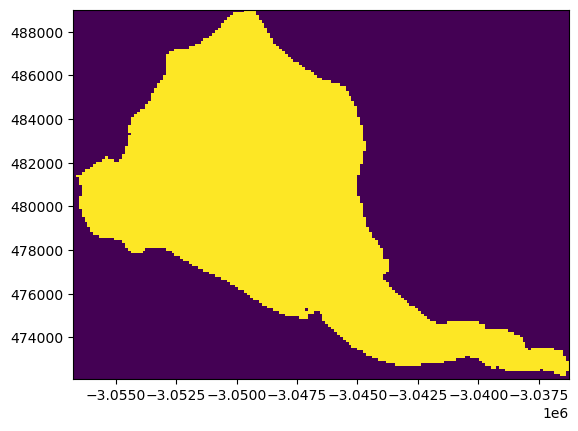

In [81]:
plt.pcolormesh(X_arr[X_MIN:X_MAX], Y_arr[Y_MIN:Y_MAX], template)

### Calculate a inversion timeframe that fits all the datacubes

In [82]:
min_date = []
max_date = []

for url in range(len(urls)):
    if mission:
        # Get the indices of the mission
        filt1 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img1'][:] == mission)
        filt2 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img2'][:] == mission)
        inds_mission = np.intersect1d(filt1[0],filt2[0])

        # Grab only the indices corresponding to the missions
        mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]
        im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')[inds_mission]
        im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')[inds_mission]
    else:
        # If 'None' was passed as a mission argument, we grab all the available data.
        inds_mission = None
        mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')
        im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')
        im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')
    
    # Get some arrays
    index_sort = np.argsort(np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]'))
    mid_dates = mid_dates[index_sort]
    im1 = im1[index_sort]
    im2 = im2[index_sort]

    # If sdate is later than the first available date, we find its corresponding index
    try:
        sdate_ind = np.where(mid_dates >= sdate)[0][0]
    except:
        sdate_ind = 0
    
    # If edate is sooner than the last available date, we find its corresponding index
    try:
        edate_ind = np.where(mid_dates > edate)[0][0]
    except:
        edate_ind = None
    
    # Create a False/True mask where True if the date is in the desired range
    mask_dates = np.full(mid_dates.shape, False)
    mask_dates[sdate_ind:edate_ind] = True

    # Keep only the values within the desired range
    mid_dates = mid_dates[mask_dates]
    im1 = im1[mask_dates]
    im2 = im2[mask_dates]

    # Check which im is the smallest (first image, it changes depending on ITS_LIVE's version)
    if im2[0] < im1[0]:
        temp = im1
        im1 = im2
        im2 = temp

    min_date.append(im1[0])
    max_date.append(im2[-1])

# Determine the min and max of the dates available in the datacubes
min_date = np.min(min_date)
max_date = np.max(max_date)

In [83]:
# Distance between two cell centers
space_interval = np.sqrt((X_arr[1]-X_arr[0])**2 + (Y_arr[1]-Y_arr[0])**2)

reg_mat_space, reg_mat_time, dates_nonum, dates, data_dict = design_matrices(urls, min_date, max_date, mission, lamb, derivative, day_interval, space_interval, sdate, edate, nb_pts_tot)

### Function to loop through every valid on-glacier pixel.

The following function calls the point's timeseries from ITS_LIVE, assembles the design matrix, and calls the inversion function. Once it is done, it stores the inversion output in the host matrices (vx & vy). It saves a copy of the matrices as a netcdf object every 10k iterations, and creates a text file printing how many iterations have been computed, every 100 iterations.

In [84]:
def looper(i, GPU, spatial_regularization, nb_pts_tot, time_reg_mat, space_reg_mat, len_pt_inverted):
    
    global vxInv
    global vyInv
    
    # Get all the points used in the inversion. 1st point is the one we are inverting for
    vxObs = [np.array(data_dict[urls[P[i][v][2]]]['zarr_store']['vx'][:,  neighbor_idx[:,P[i][v][3]][0], neighbor_idx[:,P[i][v][3]][1]][data_dict[urls[P[i][v][2]]]['index_sort']][data_dict[urls[P[i][v][2]]]['mask_dates']], dtype=np.float64) for v in range(len(P[i]))]
    vyObs = [np.array(data_dict[urls[P[i][v][2]]]['zarr_store']['vy'][:,  neighbor_idx[:,P[i][v][3]][0], neighbor_idx[:,P[i][v][3]][1]][data_dict[urls[P[i][v][2]]]['index_sort']][data_dict[urls[P[i][v][2]]]['mask_dates']], dtype=np.float64) for v in range(len(P[i]))]
    
    # Grab the nodata value
    fillvalue = vxObs[0].min()
    
    # Mask the non-valid values
    mask = [np.logical_not(np.equal(vxObs[v], fillvalue)) for v in range(len(vxObs))]

    # Mask the observed vectors
    vxObs_masked = [vxObs[v][mask[v]] for v in range(len(vxObs))]
    vyObs_masked = [vyObs[v][mask[v]] for v in range(len(vyObs))]

    # Get the length of each point
    len_pts_tot =  [len(vxObs_masked[v]) for v in range(len(vxObs))]

    # Stack the observed vectors
    vxObs_masked = np.hstack(vxObs_masked)
    vyObs_masked = np.hstack(vyObs_masked)

    # Count the amount of points
    nb_pts = len(P[i])

    # Assemble the design matrix, masked 
    # Initialize the design matrix
    if spatial_regularization:
        A_des = np.zeros((len(vxObs_masked) + SRT[0] + SRS[0], SRT[1]))
        # Fill-in the values of A_m depending on each point
        cr = 0
        cc = 0
        for v in range(nb_pts):
            A_des[cr:cr+len_pts_tot[v], cc:cc+len_pt_inverted] = data_dict[urls[P[i][v][2]]]['A_m'][mask[v]]
            cr += len_pts_tot[v]
            cc += len_pt_inverted

        # Append time and spatial regularization matrices, fitted to the amount of points we have
        A_des[cr:cr + SRT[0], :] = time_reg_mat
        A_des[cr + SRT[0]:, :] = space_reg_mat

    else:
        A_des = np.zeros((len(vxObs_masked) + SRT[0], SRT[1]))
        cr = len_pts_tot[0]
        cc = len_pt_inverted
        A_des[:cr] = data_dict[urls[P[i][0][2]]]['A_m'][mask[0]]
        A_des[cr:cr + SRT[0], :] = time_reg_mat


    # Invert the velocities
    vxInv[: , y_matches[i], x_matches[i]] = Inverter(GPU, spatial_regularization, vxObs_masked, nb_pts, len_pt_inverted, A_des, device)
    vyInv[: , y_matches[i], x_matches[i]] = Inverter(GPU, spatial_regularization, vyObs_masked, nb_pts, len_pt_inverted, A_des, device)
    
    
    # Save the amount of iterations in a text file
    if i%100 == 0:
        with open("Counter.txt", "w") as text_file:
            text_file.write(f"Counter: {i}")

    # Save the matrices along-the-way in case the algorithm fails
    if i%10000 == 0 and i != 0:

        print(f"Saved at {i}")
        
        # Get the names of all the glaciers in the datacube 
        new_ds = xr.Dataset(
            {
                "vx": (["time", "y", "x"], vxInv.cpu().numpy()),
                "vy": (["time", "y", "x"], vyInv.cpu().numpy())
            },
            coords={
                "time": ind_tot,
                "x": X_arr[X_MIN:X_MAX],
                "y": Y_arr[Y_MIN:Y_MAX]
            },
            attrs=data_dict[urls[0]]['zarr_store'].attrs,
        ).chunk({'time': 1, 'x': 100, 'y': 100})

        from dask.diagnostics import ProgressBar
        write_job = new_ds.to_netcdf(f'Cube.nc', compute=False)
        with ProgressBar():
            print(f"Writing to {'Cube.nc'}")
            write_job.compute()
            

#### Inversion function

The function determines if we use GPU acceleration or not, and finds the optimal solution for a point.

In [85]:
def Inverter(GPU, spatial_regularization, vObs_masked, nb_pts, len_pt_inverted, A_des, device):

    # Extend the observations with 0s to match the length of spacetime regularizations
    if spatial_regularization:
        vObs_masked = np.hstack((vObs_masked, np.zeros((SRT[0] + SRS[0]))))
    else:
        vObs_masked = np.hstack((vObs_masked, np.zeros((SRT[0]))))

    if GPU:
        # Migrate velocity vector to torch
        vObs_masked = torch.from_numpy(vObs_masked).to(device).double()
        # Migrate design matrix to GPU
        A_des = torch.from_numpy(A_des).to(device)
        vInv = torch.linalg.solve(A_des.T@A_des,A_des.T@(vObs_masked))[:len_pt_inverted].cpu()
    else:
        vInv = np.linalg.solve(A_des.T@A_des,A_des.T@(vObs_masked))[:len_pt_inverted]

    return vInv

#### Design Matrix components

Build the last bricks of the design matrix depending on how many points we use in the regularization & initialize host arrays for the inversion outputs



In [86]:
SRT = reg_mat_time.shape
time_reg_mat = np.zeros((nb_pts_tot*SRT[0], nb_pts_tot*SRT[1]))


# Stack time_reg_temp on the diagonal of time_reg
for i in range(0,nb_pts_tot):
    time_reg_mat[i*SRT[0]:(i+1)*SRT[0], i*SRT[1]:(i+1)*SRT[1]] = reg_mat_time

if spatial_regularization:
    # Initialize spatial regulization matrix
    space_reg_mat = np.zeros((2*SRT[0], time_reg_mat.shape[1]))
    
    space_reg_mat[:, :SRT[1]] = np.tile(reg_mat_space[0], (2,1))
    space_reg_mat[:SRT[1], SRT[1]:3*SRT[1]] = np.tile(reg_mat_space[0], 2)
    space_reg_mat[SRT[1]:2*SRT[0], 3*SRT[1]:] = np.tile(reg_mat_space[0], 2)
    SRS = space_reg_mat.shape
else: 
    space_reg_mat = None
    
# Get the shapes of the regularization matrices
SRT = time_reg_mat.shape

# Initialize velocity matrices
len_pt_inverted = len(dates)
vxInv = np.full((len_pt_inverted, template.shape[0], template.shape[1]), np.nan)
vyInv = np.full((vxInv.shape), np.nan)


# Run the inversion

If GPU then we import the necessary package and variable
At the end, store as a netcdf

In [87]:

if GPU:     
    import torch
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = None

# Run the inversions for vx and vy and populate vxInv, vyInv
for i in tqdm(range(len(y_matches))):

    looper(i, GPU, spatial_regularization, nb_pts_tot, time_reg_mat, space_reg_mat, len_pt_inverted)    

 


    



  0%|          | 38/8962 [00:10<40:57,  3.63it/s] 


KeyboardInterrupt: 

### Quick data visualization


We then plot the average of each 2D (spatial) slice to give an idea of the glacier's velocity

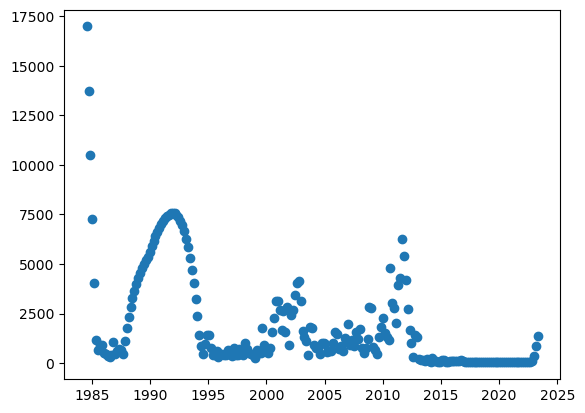

In [88]:
# Calculate velocity magnitude
mag = np.sqrt(vxInv**2+vyInv**2)

# Plot the average velocity magnitude in time
plt.scatter(dates_nonum, np.nanmean(np.nanmean(mag, axis = 2), axis = 1))

### Filter the data

**Choose a threshold to throw away velocities that are above it**

We calculate the average velocity magnitude for each spatial cell of the glacier. If a timestamp leads to X times the average velocity magnitude at that point, we throw it out.

In [89]:
X = 10  # If a velocity is 10 times above the threshold, we take it out

In [90]:
# Grab the indices where the velocity is above X times the mean
mask_mag = np.logical_not(mag <= X*np.nanmean(mag, axis = 0))

### Mask the velocities above the threshold

In [91]:
vxInv[mask_mag] = np.nan
vyInv[mask_mag] = np.nan
mag[mask_mag] = np.nan

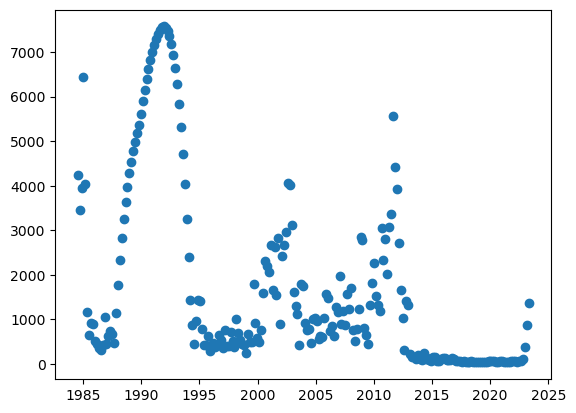

In [92]:
# Replot the average velocity magnitude now that it has been filtered
plt.scatter(dates_nonum, np.nanmean(np.nanmean(mag, axis = 2), axis = 1))

### Export the variables

We save everything as a netcdf file, chunked with dask in order to avoid RAM overflow.

In [ ]:
# Save the dataset
new_ds = xr.Dataset(
{
    "vx": (["time", "y", "x"], vxInv),
    "vy": (["time", "y", "x"], vyInv),
    "mask": (["time", "y", "x"], mask_mag),
},
coords={
    "time": ind_tot,
    "x": X_arr[X_MIN:X_MAX],
    "y": Y_arr[Y_MIN:Y_MAX]
},
attrs=data_dict[urls[0]]['zarr_store'].attrs,
).chunk({'time': 1, 'x': 100, 'y': 100})

from dask.diagnostics import ProgressBar
write_job = new_ds.to_netcdf(f'Cube.nc', compute=False)
with ProgressBar():
    print(f"Writing to {'Cube.nc'}")
    write_job.compute()   
